In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

In [2]:
def preprocess_imdb(df):
    df = df.copy()

    # GENRE ENCODING
    df['Genre_list'] = df['Genre'].apply(lambda x: [g.strip() for g in str(x).split(',')])
    mlb = MultiLabelBinarizer()
    genre_encoded = pd.DataFrame(
        mlb.fit_transform(df['Genre_list']),
        columns=mlb.classes_,
        index=df.index
    )
    df = pd.concat([df, genre_encoded], axis=1)

    # NUMERIC CLEANING
    df['Runtime'] = df['Runtime'].astype(str).str.replace('min', '', regex=False).astype(float)
    df['No_of_Votes'] = (
        df['No_of_Votes']
        .astype(str)
        .str.replace(',', '', regex=False)
        .replace('nan', np.nan)
        .astype(float)
    )

    # SCALING
    scaler = StandardScaler()
    df[['Runtime', 'No_of_Votes']] = scaler.fit_transform(df[['Runtime', 'No_of_Votes']])

    # CERTIFICATE ENCODING
    df['Certificate'] = df['Certificate'].fillna('Unknown')
    cert_encoded = pd.get_dummies(df['Certificate'], prefix='Cert')
    df = pd.concat([df.drop(columns=['Certificate']), cert_encoded], axis=1)

    # TEXT EMBEDDINGS
    model = SentenceTransformer('all-MiniLM-L6-v2')
    df['overview_emb'] = df['Overview'].apply(lambda x: model.encode(str(x)))

    # EXPAND EMBEDDINGS
    emb_df = pd.DataFrame(df['overview_emb'].to_list(), index=df.index)
    emb_df.columns = [f"emb_{i}" for i in range(emb_df.shape[1])]
    df = pd.concat([df.drop(columns=['overview_emb']), emb_df], axis=1)

    return df


In [3]:
data = pd.read_csv('/content/imdb_top_1000.csv')
data.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [4]:

# APPLY FUNCTION

processed_data = preprocess_imdb(data)
processed_data.head(3)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,Poster_Link,Series_Title,Released_Year,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,...,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,0.680529,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,...,0.026552,-0.016651,0.054256,0.096013,0.019038,-0.066977,0.008006,-0.030559,-0.016417,-0.015816
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,1.855759,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,...,0.006815,-0.111737,-0.040969,0.063892,-0.047381,-0.015489,0.091035,-0.014022,0.048909,-0.096574
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,1.036659,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,...,0.008109,-0.010922,-0.013431,0.002139,-0.055662,-0.029299,0.124012,0.074433,0.057584,-0.014860


In [5]:

# FEATURES & TARGET
Y_columns = ['IMDB_Rating']

# include all emb columns
embedding_cols = [col for col in processed_data.columns if col.startswith('emb_')]

X_columns = ['Runtime', 'No_of_Votes'] + embedding_cols + [
    'Action', 'Adventure', 'Animation', 'Biography', 'Comedy',
    'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror',
    'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller',
    'War', 'Western'
]


In [6]:
# Split Train/Test

from sklearn.model_selection import train_test_split

X = processed_data[X_columns]
y = processed_data[Y_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Linear Regression**

In [7]:
from sklearn.linear_model import LinearRegression

# Create and train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train.values.ravel())

# Predict
y_pred_lr = lr_model.predict(X_test)

# Evaluate
mae  = mean_absolute_error(y_test, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2   = r2_score(y_test, y_pred_lr)

print("## Linear Regression Results")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")


## Linear Regression Results
MAE  : 0.249
RMSE : 0.307
R²   : -0.472


In [8]:
# Taking a variable for store model's results
results = []
ridge_result = {
    "Model": "Linear Regression",
    "MAE": mae,
    "RMSE": rmse,
    "R2": r2
}
results.append(ridge_result )

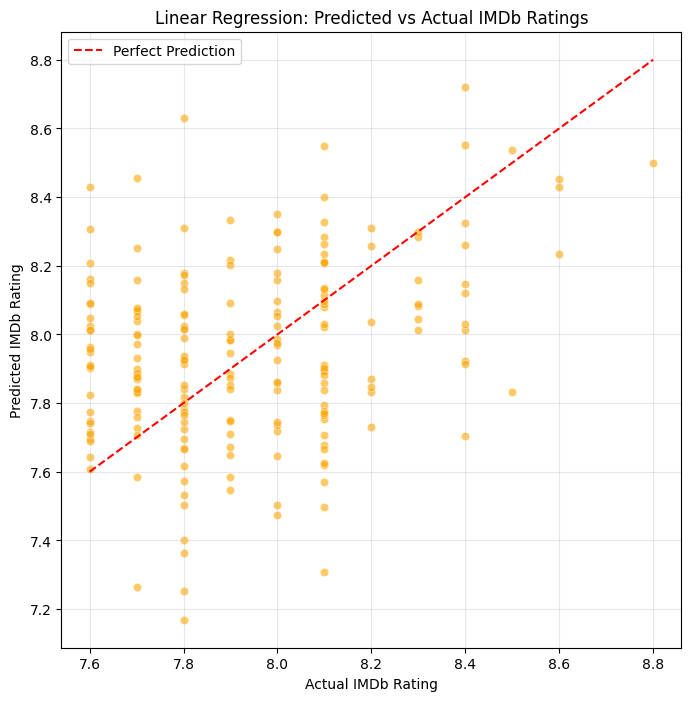

In [9]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=y_test.values.flatten(), y=y_pred_lr, alpha=0.6, color='orange')
plt.plot(
    [y_test.min().values[0], y_test.max().values[0]],
    [y_test.min().values[0], y_test.max().values[0]],
    'r--', label='Perfect Prediction'
)
plt.title("Linear Regression: Predicted vs Actual IMDb Ratings")
plt.xlabel("Actual IMDb Rating")
plt.ylabel("Predicted IMDb Rating")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Random Forest

In [10]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,         # allow trees to grow fully
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train, y_train.values.ravel())


# Predictions
y_pred_rf = rf_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf)

print(f"#Random Forest Results:")
print(f"MAE  : {mae:.3f}")
print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")




#Random Forest Results:
MAE  : 0.182
MSE  : 0.049
RMSE : 0.221
R²   : 0.241


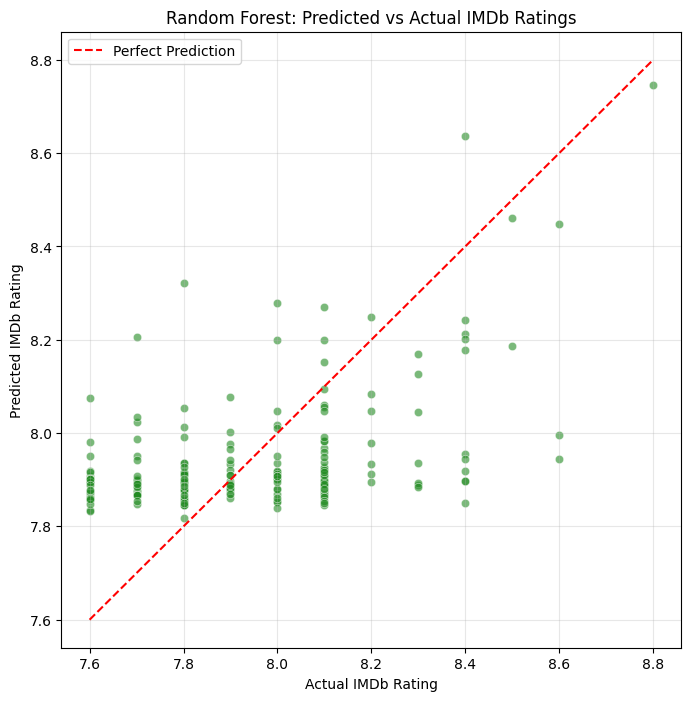

In [11]:
# plot

plt.figure(figsize=(8,8))
sns.scatterplot(x=y_test.values.flatten(), y=y_pred_rf, alpha=0.6, color="forestgreen")
plt.plot(
    [y_test.min().values[0], y_test.max().values[0]],
    [y_test.min().values[0], y_test.max().values[0]],
    'r--', label="Perfect Prediction"
)
plt.title("Random Forest: Predicted vs Actual IMDb Ratings")
plt.xlabel("Actual IMDb Rating")
plt.ylabel("Predicted IMDb Rating")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
rf_result = {
    "Model": "Random Forest",
    "MAE": mae,
    "RMSE": rmse,
    "R2": r2
}
results.append(rf_result)


# Deep Learning

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)  # Regression output
])

# Compile model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

# Train model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_loss ** 0.5:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 33.9565 - mae: 5.0316 - val_loss: 0.9375 - val_mae: 0.7592
Epoch 2/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2187 - mae: 0.8661 - val_loss: 0.6094 - val_mae: 0.6290
Epoch 3/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2651 - mae: 0.8850 - val_loss: 0.6370 - val_mae: 0.6551
Epoch 4/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8201 - mae: 0.7303 - val_loss: 0.4743 - val_mae: 0.5467
Epoch 5/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7302 - mae: 0.6600 - val_loss: 0.4307 - val_mae: 0.5225
Epoch 6/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5927 - mae: 0.6099 - val_loss: 0.4696 - val_mae: 0.5591
Epoch 7/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6712 - mae: 0.6654 - val_loss: 0.3287 - val_mae: 0.4634
Epoch 8/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5372 - mae: 0.5839 - val_loss: 0.3407 - val_mae: 0.4605
Epoch 9/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5

In [14]:
# Store results
dl_result = {
    "Model": "Deep Learning",
    "MAE": test_mae,
    "RMSE": test_loss ** 0.5,
    "R2": None
}
results.append(dl_result)

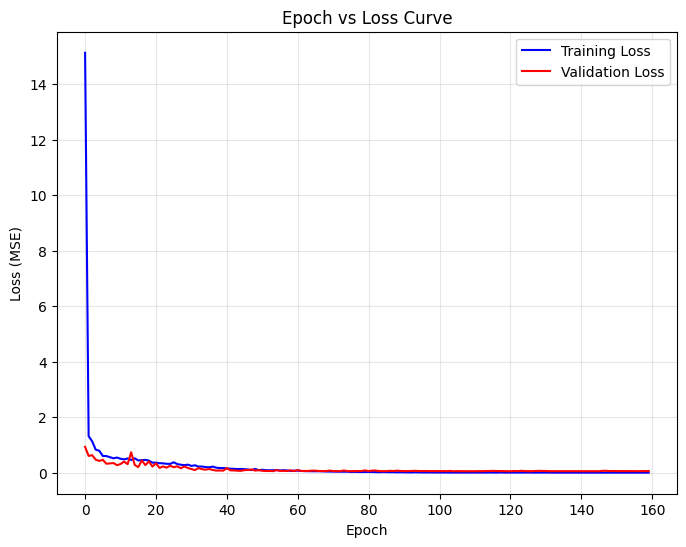

In [15]:

plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title("Epoch vs Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


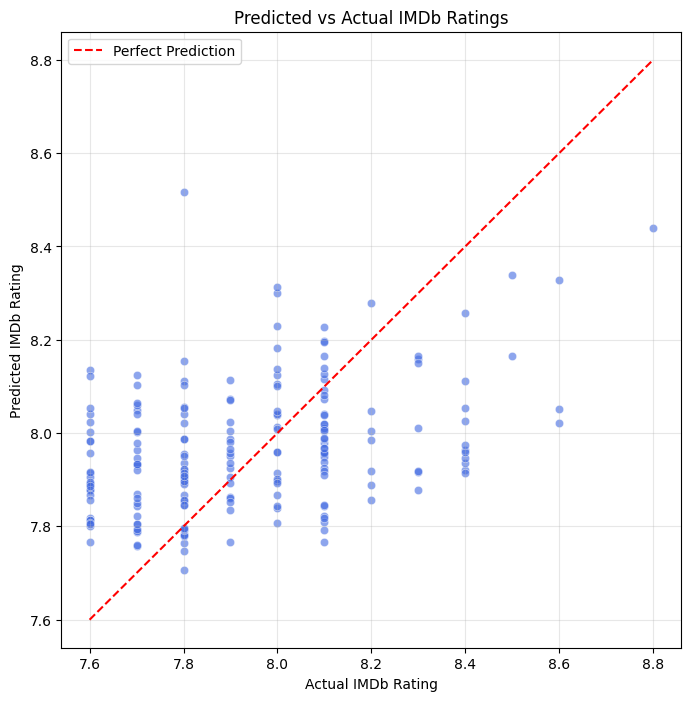

In [16]:

y_pred = model.predict(X_test).flatten()
y_true = y_test.values.flatten()

plt.figure(figsize=(8,8))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6, color="royalblue")

max_rating = max(y_true.max(), y_pred.max())
min_rating = min(y_true.min(), y_pred.min())
plt.plot([min_rating, max_rating], [min_rating, max_rating], 'r--', label='Perfect Prediction')

plt.title("Predicted vs Actual IMDb Ratings")
plt.xlabel("Actual IMDb Rating")
plt.ylabel("Predicted IMDb Rating")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [17]:


# Create comparison DataFrame
results_df = pd.DataFrame({
    'Actual_Rating': y_true,
    'Predicted_Rating': y_pred,
    'Error': y_true - y_pred,
    'Absolute_Error': np.abs(y_true - y_pred)
})

results_df.head(25)


,Actual_Rating,Predicted_Rating,Error,Absolute_Error
0,7.9,8.073430,-0.173430,0.173430
1,7.7,7.931821,-0.231821,0.231821
2,7.7,7.786988,-0.086988,0.086988
3,7.8,7.784575,0.015425,0.015425
4,8.0,8.038318,-0.038318,0.038318
5,7.8,7.954373,-0.154373,0.154373
6,7.8,8.111630,-0.311630,0.311630
7,7.9,7.906618,-0.006618,0.006618
8,7.7,7.934575,-0.234575,0.234575
9,8.2,7.918361,0.281639,0.281639


In [18]:

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest Results:")
print(f"MAE  : {mae:.3f}")
print(f"MSE  : {mse:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")


Random Forest Results:
MAE  : 0.182
MSE  : 0.049
RMSE : 0.221
R²   : 0.241


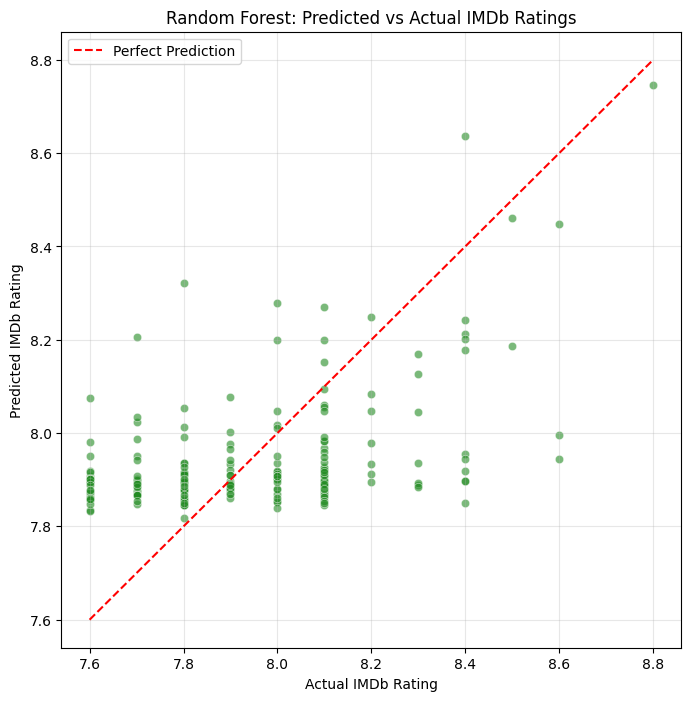

In [19]:


plt.figure(figsize=(8,8))
sns.scatterplot(x=y_test.values.flatten(), y=y_pred_rf, alpha=0.6, color="forestgreen")
plt.plot(
    [y_test.min().values[0], y_test.max().values[0]],
    [y_test.min().values[0], y_test.max().values[0]],
    'r--', label="Perfect Prediction"
)
plt.title("Random Forest: Predicted vs Actual IMDb Ratings")
plt.xlabel("Actual IMDb Rating")
plt.ylabel("Predicted IMDb Rating")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


/tmp/ipython-input-4018208715.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')


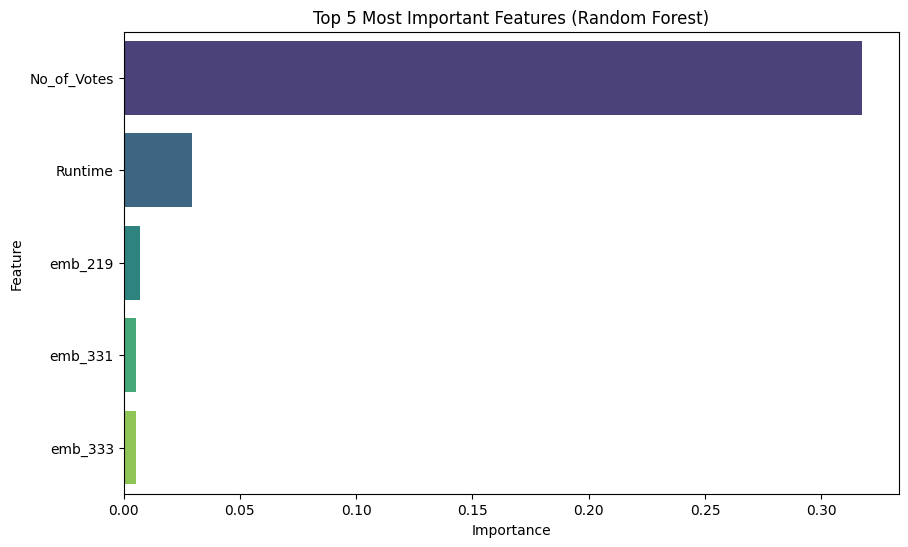

In [20]:


# Get feature importance
importances = rf_model.feature_importances_
feature_names = X_train.columns

feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(5)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title("Top 5 Most Important Features (Random Forest)")
plt.show()


# XGBOOST

In [21]:


xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    eval_metric='rmse'
)

xgb_model.fit(X_train, y_train.values.ravel())

y_pred = xgb_model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print("Simple XGBoost Model Results")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")





Simple XGBoost Model Results
MAE  : 0.184
RMSE : 0.228
R²   : 0.190


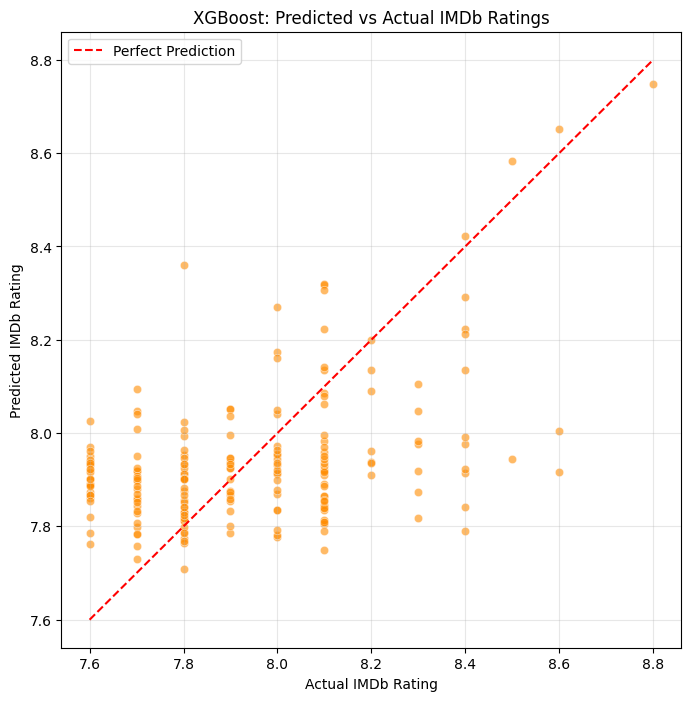

In [22]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=y_test.values.flatten(), y=y_pred, alpha=0.6, color='darkorange')
plt.plot(
    [y_test.min().values[0], y_test.max().values[0]],
    [y_test.min().values[0], y_test.max().values[0]],
    'r--', label='Perfect Prediction'
)
plt.title("XGBoost: Predicted vs Actual IMDb Ratings")
plt.xlabel("Actual IMDb Rating")
plt.ylabel("Predicted IMDb Rating")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipython-input-3542296872.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='inferno')


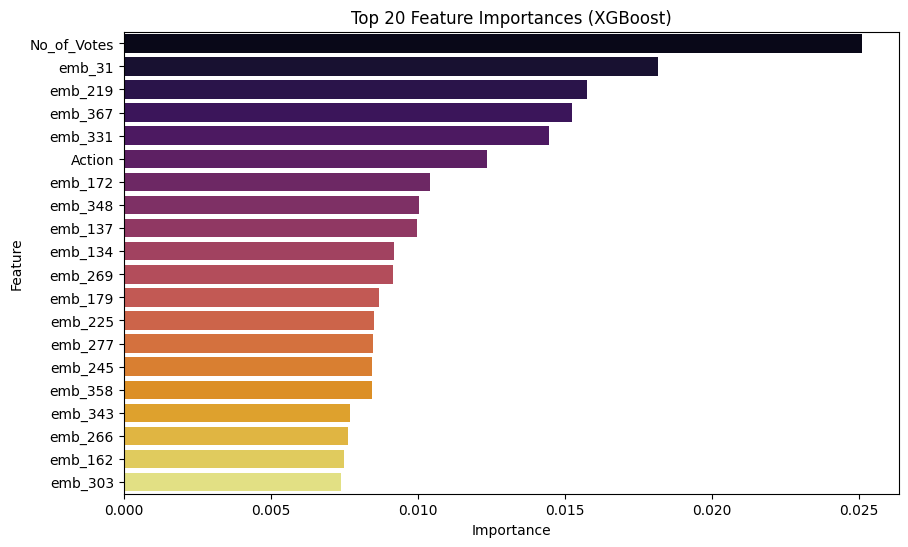

In [23]:
importances = xgb_model.feature_importances_
features = X_train.columns

feat_imp = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='inferno')
plt.title("Top 20 Feature Importances (XGBoost)")
plt.show()

In [24]:
# Store results in the global results list
dl_result = {
    "Model": "xgboost",
    "MAE": mae,
    "RMSE": rmse ** 0.5,
    "R2": r2   # optional; neural nets don’t output R² directly
}
results.append(dl_result)

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


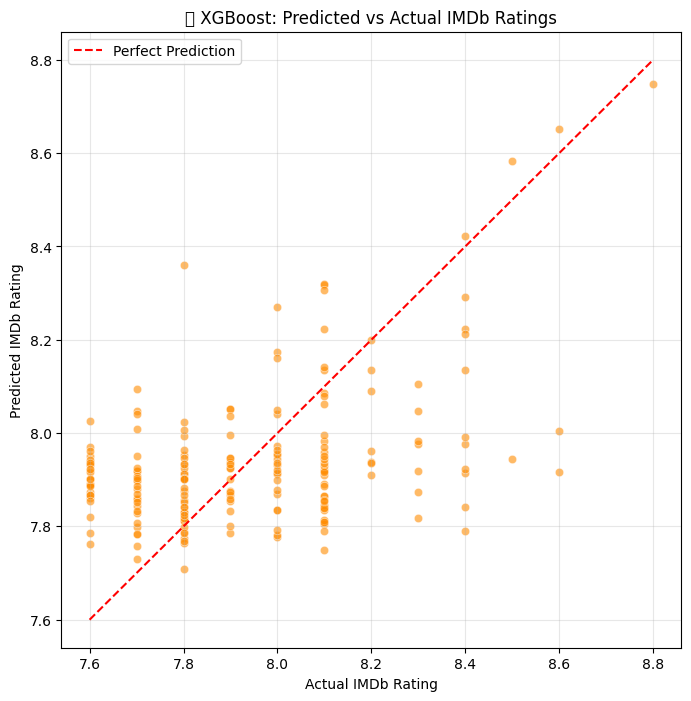

In [25]:

plt.figure(figsize=(8,8))
sns.scatterplot(x=y_test.values.flatten(), y=y_pred, alpha=0.6, color='darkorange')
plt.plot(
    [y_test.min().values[0], y_test.max().values[0]],
    [y_test.min().values[0], y_test.max().values[0]],
    'r--', label='Perfect Prediction'
)
plt.title("🎬 XGBoost: Predicted vs Actual IMDb Ratings")
plt.xlabel("Actual IMDb Rating")
plt.ylabel("Predicted IMDb Rating")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


/tmp/ipython-input-698607096.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='inferno')


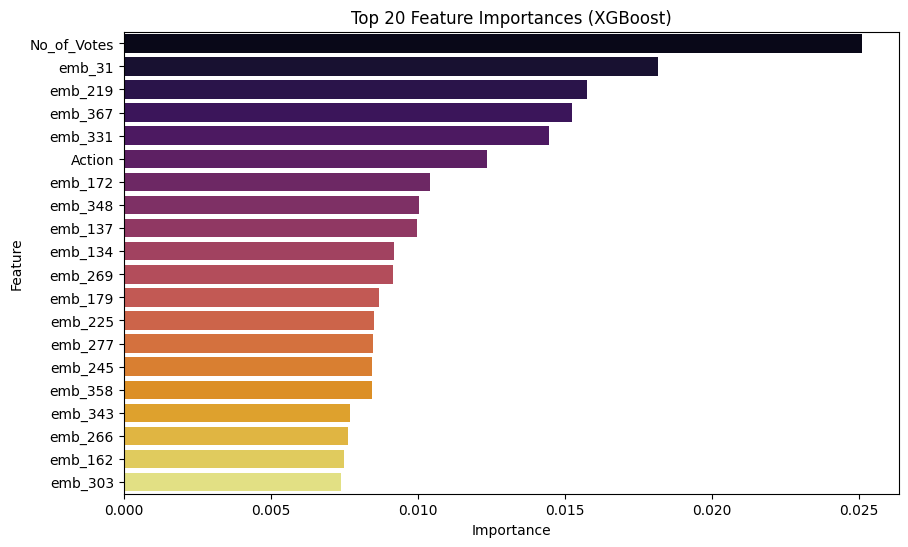

In [26]:
import pandas as pd

importances = xgb_model.feature_importances_
features = X_train.columns

feat_imp = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='inferno')
plt.title("Top 20 Feature Importances (XGBoost)")
plt.show()


In [27]:
results

[{'Model': 'Linear Regression',
  'MAE': 0.24883803291784573,
  'RMSE': np.float64(0.3071756096865647),
  'R2': -0.4719339695855598},
 {'Model': 'Random Forest',
  'MAE': 0.1818833333333329,
  'RMSE': np.float64(0.220570943487829),
  'R2': 0.2410529590803846},
 {'Model': 'Deep Learning',
  'MAE': 0.19346734881401062,
  'RMSE': 0.23783087770931477,
  'R2': None},
 {'Model': 'xgboost',
  'MAE': 0.18364295363426208,
  'RMSE': np.float64(0.47735586645979033),
  'R2': 0.19000238180160522}]

In [28]:


results_df = pd.DataFrame(results)
print(results_df)


               Model       MAE      RMSE        R2
0  Linear Regression  0.248838  0.307176 -0.471934
1      Random Forest  0.181883  0.220571  0.241053
2      Deep Learning  0.193467  0.237831       NaN
3            xgboost  0.183643  0.477356  0.190002


/tmp/ipython-input-1850291724.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=results_df, palette='viridis')


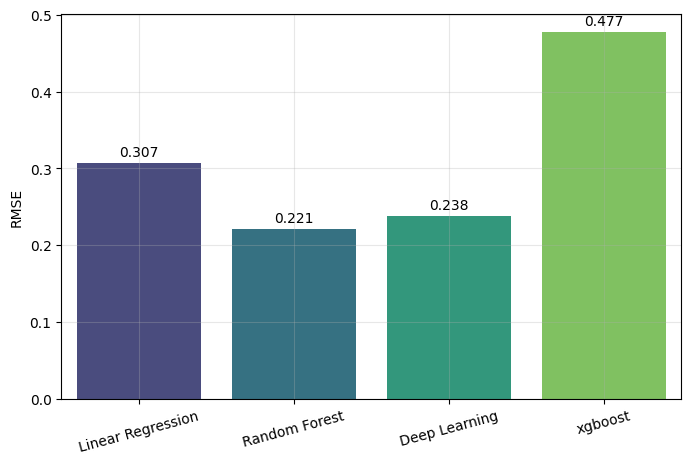

In [29]:


plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='RMSE', data=results_df, palette='viridis')

# Annotate values on top of bars
for i, v in enumerate(results_df['RMSE']):
    plt.text(i, v + 0.005, f"{v:.3f}", ha='center', va='bottom', fontsize=10)

# plt.title("Model Comparison by RMSE (Lower = Better)")
plt.xlabel("")
plt.ylabel("RMSE")
plt.xticks(rotation=15)
plt.grid(True, alpha=0.3)
plt.show()


/tmp/ipython-input-2514093407.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=results_df, palette='magma')


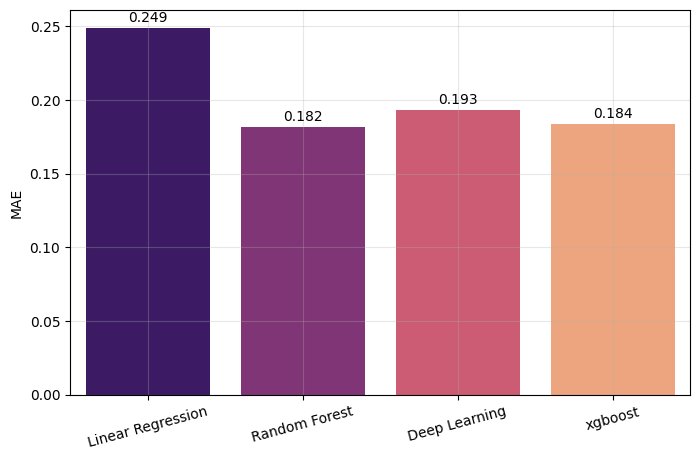

In [30]:
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='MAE', data=results_df, palette='magma')

for i, v in enumerate(results_df['MAE']):
    plt.text(i, v + 0.002, f"{v:.3f}", ha='center', va='bottom', fontsize=10)

# plt.title("Model Comparison by MAE (Lower = Better)")
plt.xlabel("")
plt.ylabel("MAE")
plt.xticks(rotation=15)
plt.grid(True, alpha=0.3)
plt.show()


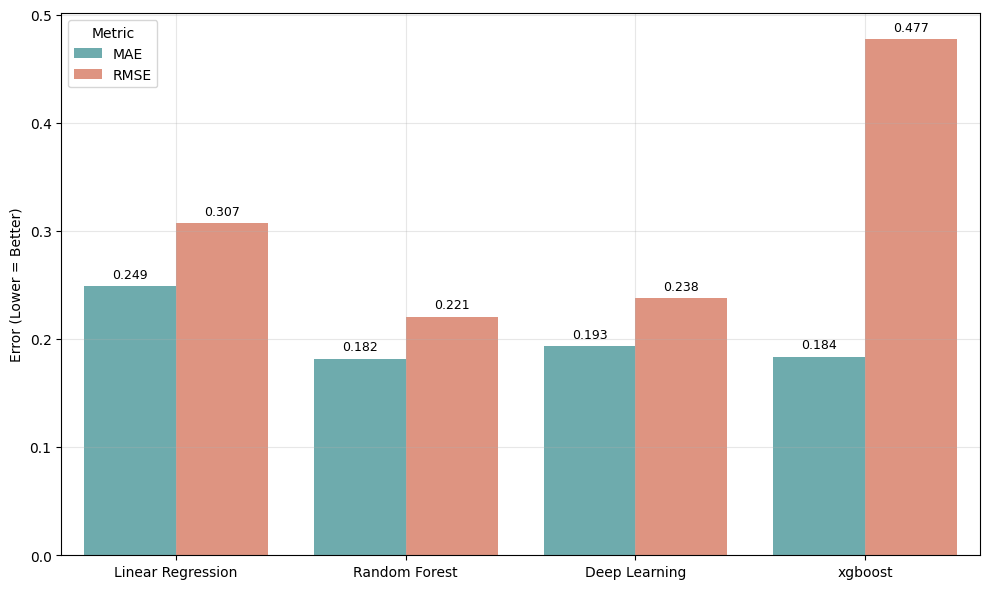

In [31]:


# Melt the results DataFrame for grouped plotting
results_melted = results_df.melt(
    id_vars='Model',
    value_vars=['MAE', 'RMSE'],
    var_name='Metric',
    value_name='Score'
)

# Plot
plt.figure(figsize=(10,6))
ax = sns.barplot(
    x='Model',
    y='Score',
    hue='Metric',
    data=results_melted,
    palette=['#64b5b7', '#ee8b71']
)

plt.ylabel("Error (Lower = Better)")
plt.xlabel("")
plt.legend(title='Metric')
plt.grid(True, alpha=0.3)

for p in ax.patches:
    height = p.get_height()
    if height > 0.001:
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + 0.005,
            f'{height:.3f}',
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.tight_layout()
plt.show()


In [35]:

y_true = y_test.values.flatten()

y_pred_lr     = lr_model.predict(X_test)
y_pred_rf     = rf_model.predict(X_test)
y_pred_xgb    = xgb_model.predict(X_test)
y_pred_dl     = model.predict(X_test).flatten()

comparison_df = pd.DataFrame({
    'Actual_Rating': y_true,
    'Linear_Regression': y_pred_lr,
    'Random_Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'Deep_Learning': y_pred_dl
})
comparison_df = comparison_df.round(2)

print("Comparison of Actual vs Predicted Ratings")
comparison_df.head(10)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Comparison of Actual vs Predicted Ratings


,Actual_Rating,Linear_Regression,Random_Forest,XGBoost,Deep_Learning
0,7.9,7.71,7.98,7.95,8.07
1,7.7,7.93,8.21,8.05,7.93
2,7.7,7.97,7.88,7.88,7.79
3,7.8,7.50,7.82,7.81,7.78
4,8.0,7.97,8.02,8.04,8.04
5,7.8,7.62,7.90,7.90,7.95
6,7.8,7.84,7.88,7.92,8.11
7,7.9,7.55,7.90,7.88,7.91
8,7.7,8.46,7.90,7.95,7.93
9,8.2,7.87,8.08,8.14,7.92
